In [1]:
import numpy as np
import cvxpy as cp
import scipy.io
import matplotlib.pyplot as plt

## Problem 1 B

In [2]:
data_train = scipy.io.loadmat("./overlap_case/train_overlap.mat")
data_test = scipy.io.loadmat("./overlap_case/test_overlap.mat")

In [3]:
A = data_train["A"]
B = data_train["B"]

test = data_test["X_test"]
test_label = data_test["true_labels"].ravel()

In [19]:
preds_A = np.matmul(A.T, normal_vector) - gamma
preds_A = np.array([1 if p > 0 else -1 for p in preds_A])

preds_B = np.matmul(B.T, normal_vector) - gamma
preds_B = np.array([1 if p > 0 else -1 for p in preds_B])

In [28]:
n = 100 # convex combination of 100 data points
drange = np.arange(0.001, 0.999, 0.001) # tunable param for reduced convex hull
opt_values = []
acc_values = []

# search for best value of d
for d in drange:
    u = cp.Variable((n, 1))
    v = cp.Variable((n, 1))
    ones = np.ones((1,100))

    prob = cp.Problem(cp.Minimize( cp.square(cp.norm2(cp.matmul(A,u)-cp.matmul(B,v))) ),
                     [
                         cp.matmul(ones,u) == 1,
                         cp.matmul(ones,v) == 1,
                         u >= 0,
                         v >= 0,
                         d*ones.T >= u,
                         d*ones.T >= v
                     ])
    prob.solve()
    if prob.value != np.inf:
        u_opt = u.value
        v_opt = v.value

        A_opt = np.matmul(A, u_opt)
        B_opt = np.matmul(B, v_opt)

        gamma = 0.5*(np.linalg.norm(A_opt)**2-np.linalg.norm(B_opt)**2)
        normal_vector = A_opt - B_opt
        normal_vector = normal_vector
        
        # prediction
        preds_A = np.matmul(A.T, normal_vector) - gamma
        preds_A = np.array([1 if p > 0 else -1 for p in preds_A])
        
        preds_B = np.matmul(B.T, normal_vector) - gamma
        preds_B = np.array([1 if p > 0 else -1 for p in preds_B])

        # calculate accuracy
        true_pred = list(preds_A == 1) + list(preds_B == -1)
        acc = sum(true_pred)/len(true_pred)

        acc_values.append(acc)
        opt_values.append(prob.value)
    else:
        acc_values.append(0)
        opt_values.append(np.inf)

In [29]:
# d_best = drange[np.argmin(opt_values)]
# print("optimal d is {:.2f}".format(d_best))

d_best = drange[np.argmax(acc_values)]
print("optimal d is {:.2f}".format(d_best))

optimal d is 0.02


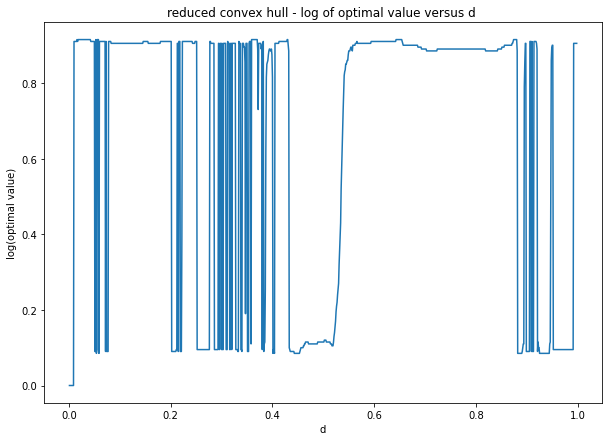

In [30]:
fig = plt.figure(figsize=(10,7))
# plt.plot(drange, np.log(opt_values))
plt.plot(drange, acc_values)
plt.title("reduced convex hull - log of optimal value versus d ")
plt.xlabel("d")
plt.ylabel("log(optimal value)")
plt.show()

In [31]:
u = cp.Variable((n, 1))
v = cp.Variable((n, 1))
ones = np.ones((1,100))

d = d_best

prob = cp.Problem(cp.Minimize( cp.square(cp.norm2(cp.matmul(A,u)-cp.matmul(B,v))) ),
                 [
                     cp.matmul(ones,u) == 1,
                     cp.matmul(ones,v) == 1,
                     u >= 0,
                     v >= 0,
                     d*ones.T >= u,
                     d*ones.T >= v
                 ])

In [32]:
prob.solve()
print("The optimal value is", prob.value)
u_opt = u.value
v_opt = v.value

A_opt = np.matmul(A, u_opt)
B_opt = np.matmul(B, v_opt)

gamma = 0.5*(np.linalg.norm(A_opt)**2-np.linalg.norm(B_opt)**2)
normal_vector = A_opt - B_opt
normal_vector = normal_vector

The optimal value is 3.088788850811897


In [33]:
x_lin = np.linspace(-5, 5, 50)
y_lin = (-x_lin*normal_vector[0][0] + gamma)/normal_vector[1][0]

In [34]:
# prediction
preds = np.matmul(test.T, normal_vector) - gamma
preds = np.array([1 if p > 0 else -1 for p in preds])

# calculate accuracy
true_pred = preds == test_label
acc = sum(true_pred)/len(true_pred)
print("test accuracy = {:.2f}".format(acc))

test accuracy = 0.98


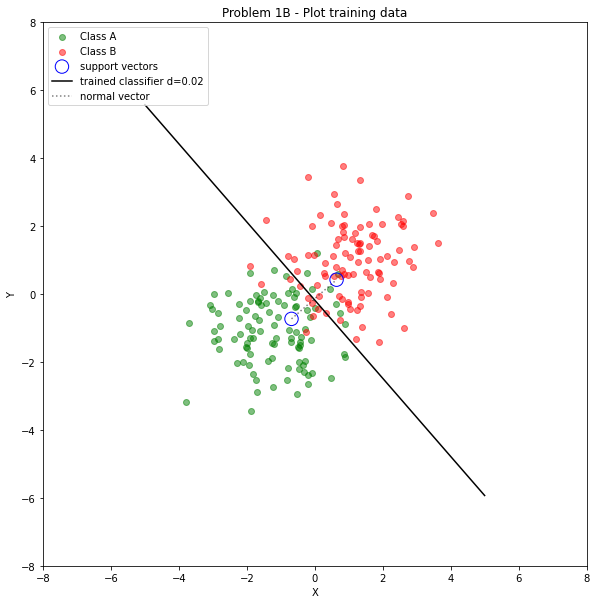

In [38]:
fig = plt.figure(figsize=(10,10))
plt.scatter(A[0,:],A[1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(B[0,:],B[1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier d={:.2f}'.format(d_best), color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 1B - Plot training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8 )
plt.ylim(-8, 8 )
plt.show()

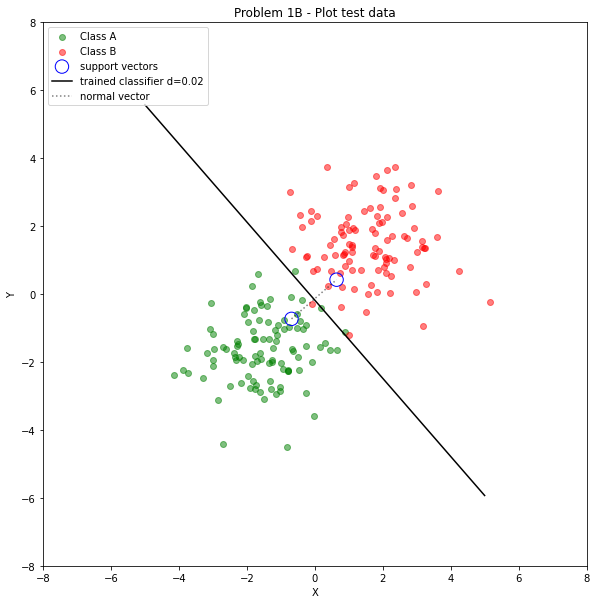

In [37]:
fig = plt.figure(figsize=(10,10))

plt.scatter(test[:,test_label==1][0,:],test[:,test_label==1][1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(test[:,test_label==-1][0,:],test[:,test_label==-1][1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier d={:.2f}'.format(d_best), color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 1B - Plot test data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8 )
plt.ylim(-8, 8 )
plt.show()